### Задача №1

Вы работаете в небольшой компании, где есть маркетолог, но нет аналитика. Маркетолог просит вас определить LTV пользователя: это поможет определить затраты на привлечение новых клиентов.

Вы посмотрели логи, там есть два набора данных: визиты пользователей на сервис и данные по покупкам. У каждого визита есть источник, а также устройство, с которого заходил пользователь.

Обозначения в файлах:

<b>start_dt</b> — дата старта визита,

<b>start_ts</b> — дата и время старта визита,

<b>end_ts</b> — дата окончания визита,

<b>uid</b> — идентификатор пользователя,

<b>source_id</b> — id источника визита,

<b>device</b> — устройство,

<b>buy_ts</b> — дата и время покупки,

<b>revenue</b> — доход в y.e.

Чему на ваш взгляд равен LTV пользователей? Как вы его рассчитали? Есть ли у вас рекомендации по его улучшению?

### Подготовка решения

#### Разберемся с определениями

Просмотрев несколько источников (<a href="https://yandex.ru/adv/edu/direct/pokazateli-effektivnosti/ltv">yandex</a>, <a href="https://habr.com/ru/post/292312/">habr</a>, <a href="https://vc.ru/marketing/140067-schitaem-ltv-klienta-pochemu-eto-tak-vazhno-dlya-biznesa-dostavki">vc</a>, <a href="https://www.carrotquest.io/blog/ltv-lifetime-value-schitaem/">carrotquest</a>), стало ясно, что путаница в понятиях определенно существует.

**LTV (lifetime value)** — это прибыль компании, полученная от одного клиента за всё время сотрудничества с ним. LTV отвечает на вопрос, сколько денег вам приносит клиент.

***Своими словами*** : сколько денег принесет пользователь, пока он активен, за выбранный нами период наблюдений.

**Lifetime** — это метрика, которая показывает, в течение какого времени человек остается активным пользователем продукта.

***Каких пользователей считать активными клиентами?*** Тут нужно знать, что существуют такие показатели как CLV или CLTV (одно и то же, означает customer lifetime value). LTV (lifetime value) считается от установок (все уникальные активные пользователи в рассматриваемом периоде), а CLTV (customer lifetime value) от платящих пользователей (подмножество уникальных активных пользователей, которые сделали хотя бы 1 заказ в рассматриваемом периоде).


***Как определить Lifetime?*** Варианты: а) посчитать для всех пользователей за период наблюдений интервал от первого действия (регистрация) до последнего (последний выход из сервиса), б) все то же самое, только прибавить некий период неактивности (время с последней активности, в течение которого мы еще готовы считать пользователя активным, т.е. вероятность его возвращения высока, а по истечении которого причислим пользователя к навечно покинувшим сервис, если конечно он потом неожиданно не вернется). Будем использовать вариант б.

**Какие способы расчета LTV существуют?** При выборе способо расчета будем исходить из имеющихся данных, а также из отсутствия данных о стоимости привлечения пользователей.


***1. Простой или исторический***:

$$LTV = Lifetime * ARPU$$

Где: $ARPU$ - средняя прибыль от одного клиента за период (Общий доход за период / Количество активных пользователей за период).

$$ARPU =  \frac{TR}{TU} $$

Где: $TR$ - total revenue, общий доход от всех пользователей за период, $TU$ - total users, общее количество пользователей, которые были активны в рассматриваемом периоде. 

***2. Сложный***:

$$LTV = AOV * RPR * Lifetime$$

Где: $AOV$ - аverage order value, средняя стоимость заказа или средний чек, $RPR$ - repeat purchase rates, частота повторных покупок.

### Решение

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

from scipy import integrate
from sklearn.cluster import KMeans
import statistics

import calendar
from datetime import datetime
from datetime import timedelta, date

import warnings
warnings.filterwarnings('ignore')

Прочитаем файл purchases

In [2]:
purchases = pd.read_csv('purchases', delimiter='\t')
purchases.head(5)

,buy_ts,uid,revenue
0,23.07.2016 19:13:54,3492372810,"1,47"
1,06.11.2016 02:48:27,1564753091,"1,11"
2,31.01.2017 20:32:42,1385616391,"16,8"
3,11.01.2017 10:52:11,2636761148,11
4,25.11.2016 18:57:09,2945629974,"4,89"


Приведем данные по столбцам к нужным типам

In [3]:
purchases.buy_ts = pd.to_datetime(purchases.buy_ts)
def replace_commas(string): return string.replace(',', '.')
purchases.revenue = purchases.revenue.apply(lambda x: replace_commas(x))
purchases.revenue = purchases.revenue.astype('float32')
purchases['buy_ts_unixtime'] = purchases['buy_ts'].apply(lambda x: x.timestamp())

purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75716 entries, 0 to 75715
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   buy_ts           75716 non-null  datetime64[ns]
 1   uid              75716 non-null  int64         
 2   revenue          75716 non-null  float32       
 3   buy_ts_unixtime  75716 non-null  float64       
dtypes: datetime64[ns](1), float32(1), float64(1), int64(1)
memory usage: 2.0 MB


Прочитаем файл visits

In [4]:
visits = pd.read_csv('visits', delimiter='\t')
visits['idx'] = visits.index
visits.head(5)

,device,end_ts,source_id,start_dt,start_ts,uid,idx
0,desktop,2016-11-30T11:04:17Z,2,2016-11-30,2016-11-30T10:53:49Z,3758486201,0
1,desktop,2016-11-10T23:16:57Z,4,2016-11-10,2016-11-10T23:08:04Z,2933941628,1
2,desktop,2016-10-19T18:51:56Z,1,2016-10-19,2016-10-19T18:48:16Z,1465872791,2
3,desktop,2017-01-12T20:51:55Z,9,2017-01-12,2017-01-12T20:50:10Z,2751875787,3
4,touch,2016-07-23T19:17:19Z,4,2016-07-23,2016-07-23T19:10:57Z,3492372810,4


Выведем массив колонок visits

In [5]:
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_dt', 'start_ts', 'uid', 'idx'], dtype='object')

Выведем массив уникальных device's

In [6]:
visits.device.unique()

array(['desktop', 'touch'], dtype=object)

Выведем массив уникальных source_id's

In [7]:
np.sort(visits.source_id.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10])

Приведем данные по столбцам к нужным типам и создадим вспомогательные поля, в которые запишем end_ts и start_ts, выраженные в юникс-времени

In [8]:
for c in visits.columns[[1,3,4]]:
    visits[c]= pd.to_datetime(visits[c])
    
visits['end_ts_unixtime'] = visits['end_ts'].apply(lambda x: x.timestamp())
visits['start_ts_unixtime'] = visits['start_ts'].apply(lambda x: x.timestamp())

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720679 entries, 0 to 720678
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   device             720679 non-null  object             
 1   end_ts             720679 non-null  datetime64[ns, UTC]
 2   source_id          720679 non-null  int64              
 3   start_dt           720679 non-null  datetime64[ns]     
 4   start_ts           720679 non-null  datetime64[ns, UTC]
 5   uid                720679 non-null  int64              
 6   idx                720679 non-null  int64              
 7   end_ts_unixtime    720679 non-null  float64            
 8   start_ts_unixtime  720679 non-null  float64            
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 49.5+ MB


Определим период наблюдений по visits (заказы из purchases оформлены в период между start_ts первого визита и end_ts последнего визита)

In [9]:
start = visits['start_ts'].min()
end = visits['end_ts'].max()

duration = end - start
print(f'--VISITS--' + 
      f'\nStart: {start}' + 
      f'\nEnd: {end}' + 
      f'\nDuration: {duration}')

--VISITS--
Start: 2016-06-01 00:01:43+00:00
End: 2017-06-01 01:28:24+00:00
Duration: 365 days 01:26:41


Видим, что период наблюдений равен 365 дней + 1,5 часа. Думаю, мы вправе в дальнейшем округлить период наблюдений до 1 года.

Посмотрим на распределение пользователей по device's

In [10]:
visits.groupby('device').count().iloc[:,0]

device
desktop    527216
touch      193463
Name: end_ts, dtype: int64

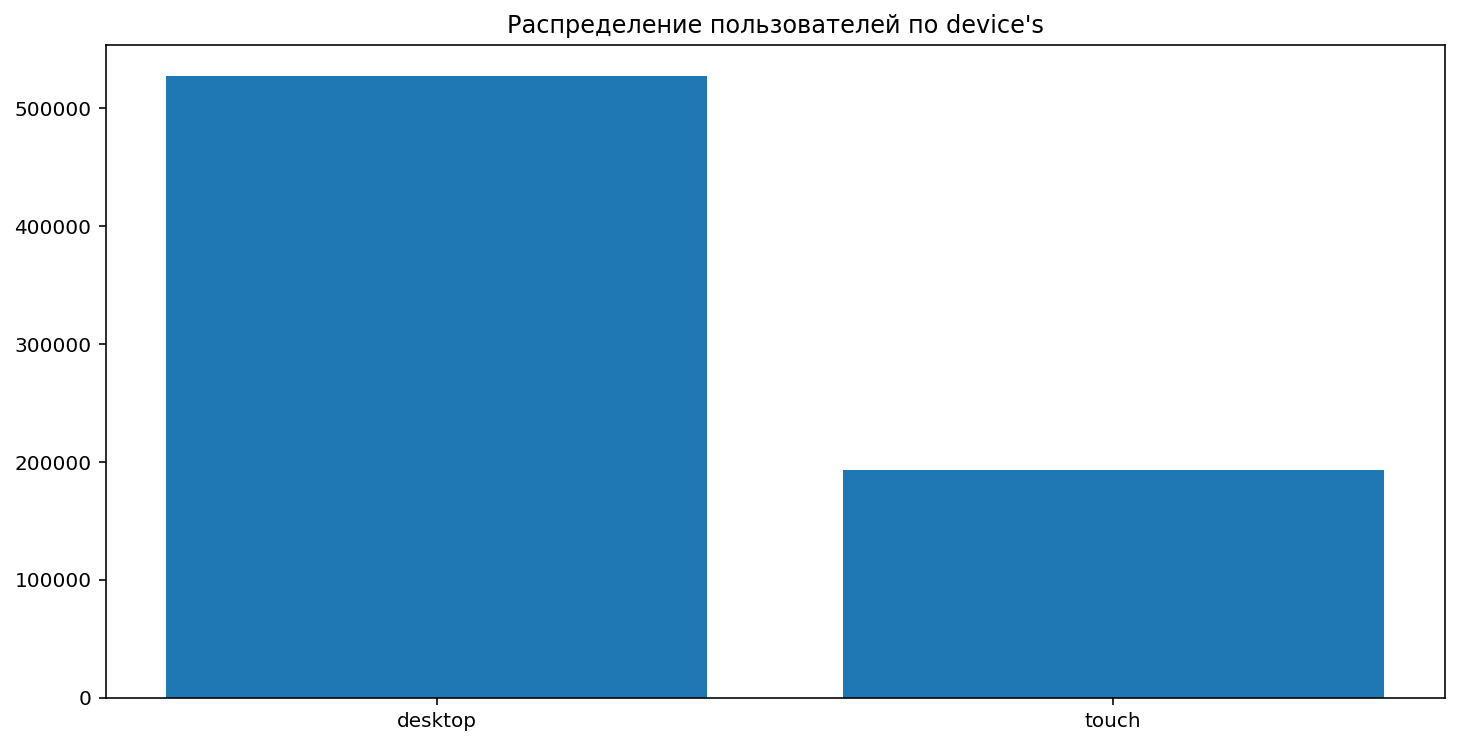

In [11]:
x = visits.groupby('device').count().iloc[:,0].index
y = visits.groupby('device').count().iloc[:,0].values

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title("Распределение пользователей по device's")

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

In [12]:
freq = visits.groupby('device').count().iloc[0,0] / visits.groupby('device').count().iloc[1,0]
print(f"Пользователи заходят с десктопов в {round(freq, 1)} раз чаще, чем с устройств с сенсорным экраном.")

Пользователи заходят с десктопов в 2.7 раз чаще, чем с устройств с сенсорным экраном.


In [13]:
multidevice_users_count = len(set([i[1] for i in visits.groupby(['device', 'uid']).count().loc[['desktop'],:].index]) & \
set([i[1] for i in visits.groupby(['device', 'uid']).count().loc[['touch'],:].index]))
print(f"Из {len(visits.uid.unique())} уникальных пользователей {multidevice_users_count} заходят с обоих типов устройств"+\
      f"({multidevice_users_count/len(visits.uid.unique())*100:.2f}% подписчиков)")

Из 380121 уникальных пользователей 17829 заходят с обоих типов устройств(4.69% подписчиков)


Можно принять, что пользователи хорошо кластеризуются на 3 когорты: "десктопщики", "тачскринщики" и "универсалы".

In [14]:
dt = set([i[1] for i in visits.groupby(['device', 'uid']).count().loc[['desktop'],:].index])
ts = set([i[1] for i in visits.groupby(['device', 'uid']).count().loc[['touch'],:].index])
pure_dt = dt - ts
pure_ts = ts - dt
universals = dt & ts
assert((len(pure_dt)+len(pure_ts)+len(universals)) == len(visits.uid.unique()))

Посмотрим на распределение пользователей по source_id's

In [15]:
visits.groupby('source_id').count().iloc[:,0]

source_id
1      68999
2      96117
3     170824
4     204146
5     134076
6         13
7         91
9      26494
10     19919
Name: device, dtype: int64

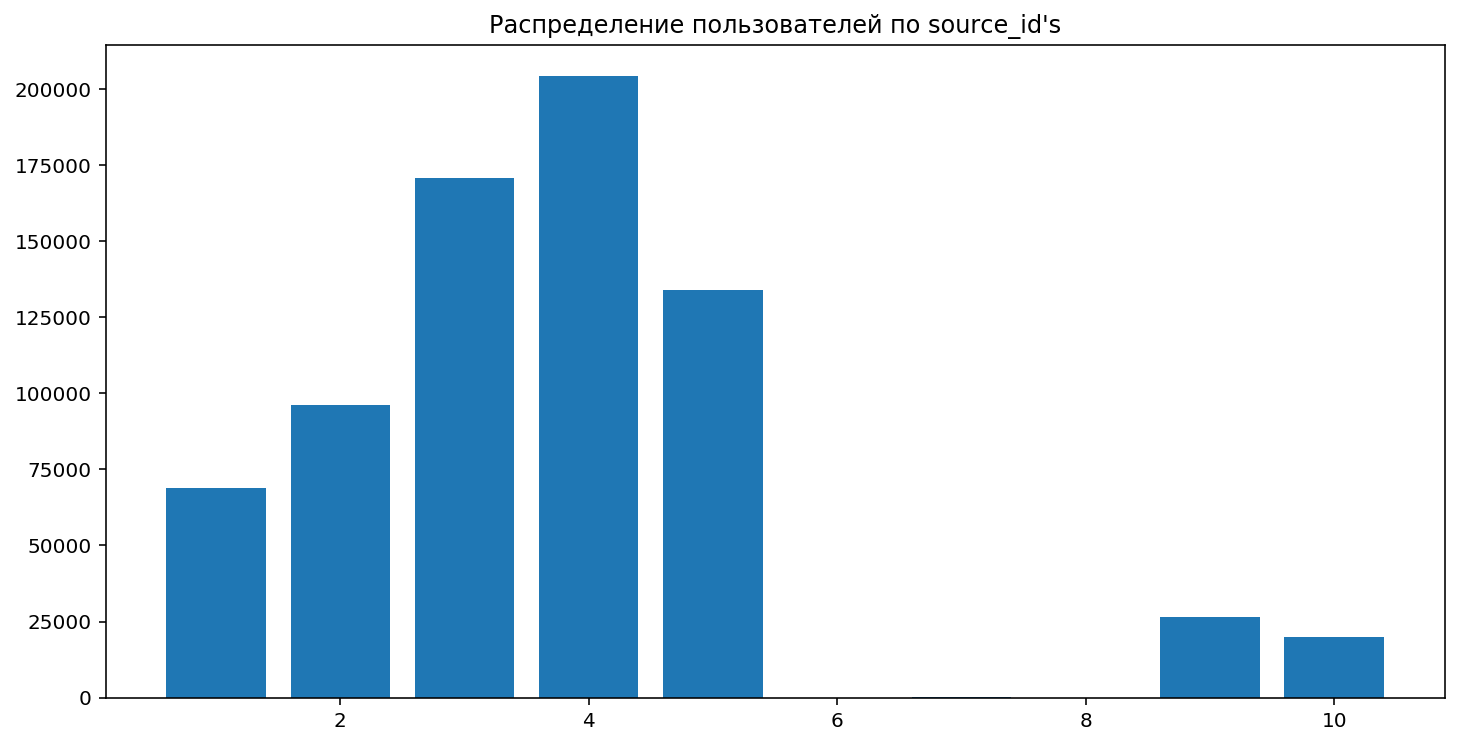

In [16]:
x = visits.groupby('source_id').count().iloc[:,0].index
y = visits.groupby('source_id').count().iloc[:,0].values

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title("Распределение пользователей по source_id's")

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

Визитов с source_id 8 совсем нет, а с 6 и 7 - крайне мало. 

***1. Простой метод расчета***:

Посчитаем общий доход за период и количество активных пользователей за период, чтобы вычислить ARPU

Считаем ARPU за период 1 год. Тут не нужно определять, какие из пользователей считаются активными, а какие - нет. Все в течение года были активны хоть раз.

In [17]:
total_revenue = purchases.revenue.sum()
assert(set(purchases.uid) - set(visits.uid) == set())
active_users = visits.uid.unique() 
arpu = total_revenue/active_users.shape[0]
print("Для всей выборки пользователей")
print(f'Total revenue: {round(total_revenue)}\nActive users: {active_users.shape[0]}')
print(f'ARPU: {round(arpu, 2)}')

Для всей выборки пользователей
Total revenue: 370824.0
Active users: 380121
ARPU: 0.98


In [18]:
# Для когорты desktop
total_revenue_dt = purchases.loc[purchases.uid.isin(pure_dt)].revenue.sum()
active_users_dt = visits.loc[visits.uid.isin(pure_dt)].uid.unique() 
arpu_dt = total_revenue_dt/active_users_dt.shape[0]
print("Для когорты desktop")
print(f'Total revenue: {round(total_revenue_dt)}\nActive users: {active_users_dt.shape[0]}')
print(f'ARPU: {round(arpu_dt, 2)}')

# Для когорты touchscreen
total_revenue_ts = purchases.loc[purchases.uid.isin(pure_ts)].revenue.sum()
active_users_ts = visits.loc[visits.uid.isin(pure_ts)].uid.unique() 
arpu_ts = total_revenue_ts/active_users_ts.shape[0]
print("Для когорты touchscreen")
print(f'Total revenue: {round(total_revenue_ts)}\nActive users: {active_users_ts.shape[0]}')
print(f'ARPU: {round(arpu_ts, 2)}')

# Для когорты universals
total_revenue_un = purchases.loc[purchases.uid.isin(universals)].revenue.sum()
active_users_un = visits.loc[visits.uid.isin(universals)].uid.unique() 
arpu_un = total_revenue_un/active_users_un.shape[0]
print("Для когорты universals")
print(f'Total revenue: {round(total_revenue_un)}\nActive users: {active_users_un.shape[0]}')
print(f'ARPU: {round(arpu_un, 2)}')

Для когорты desktop
Total revenue: 264480.0
Active users: 257445
ARPU: 1.03
Для когорты touchscreen
Total revenue: 36066.0
Active users: 104847
ARPU: 0.34
Для когорты universals
Total revenue: 70278.0
Active users: 17829
ARPU: 3.94


In [19]:
print(f"Пользователи из когорты universals в {arpu_un/arpu_dt:.1f} раза прибыльнее, чем desktop, "
      + f"и в {arpu_un/arpu_ts:.1f} раза прибыльнее, чем touchscreen")

Пользователи из когорты universals в 3.8 раза прибыльнее, чем desktop, и в 11.5 раза прибыльнее, чем touchscreen


Теперь посчитаем Lifetime

Если считать Lifetime способом а) (описано выше):

In [20]:
start_lt = visits[['uid', 'start_ts_unixtime']].groupby('uid').min().sort_values(by=['uid'])
end_lt   = visits[['uid', 'end_ts_unixtime']].groupby('uid').max().sort_values(by=['uid'])
all_lives = end_lt.end_ts_unixtime - start_lt.start_ts_unixtime
print(f'Продолжительность периода от первого до последнего визита для каждого уникального пользователя: {all_lives}')

Продолжительность периода от первого до последнего визита для каждого уникального пользователя: uid
4245              172.0
5097              331.0
8896              546.0
21017            1537.0
30696             266.0
                ...    
4294888657        755.0
4294905017        646.0
4294943796        238.0
4294952283        358.0
4294953781    6282250.0
Length: 380121, dtype: float64


In [21]:
# Для когорты desktop
start_lt_dt = visits.loc[visits.uid.isin(pure_dt)][['uid', 'start_ts_unixtime']].groupby('uid').min().sort_values(by=['uid'])
end_lt_dt   = visits.loc[visits.uid.isin(pure_dt)][['uid', 'end_ts_unixtime']].groupby('uid').max().sort_values(by=['uid'])
all_lives_dt = end_lt_dt.end_ts_unixtime - start_lt_dt.start_ts_unixtime
# Для когорты touchscreen
start_lt_ts = visits.loc[visits.uid.isin(pure_ts)][['uid', 'start_ts_unixtime']].groupby('uid').min().sort_values(by=['uid'])
end_lt_ts   = visits.loc[visits.uid.isin(pure_ts)][['uid', 'end_ts_unixtime']].groupby('uid').max().sort_values(by=['uid'])
all_lives_ts = end_lt_ts.end_ts_unixtime - start_lt_ts.start_ts_unixtime
# Для когорты universals
start_lt_un = visits.loc[visits.uid.isin(universals)][['uid', 'start_ts_unixtime']].groupby('uid').min().sort_values(by=['uid'])
end_lt_un   = visits.loc[visits.uid.isin(universals)][['uid', 'end_ts_unixtime']].groupby('uid').max().sort_values(by=['uid'])
all_lives_un = end_lt_un.end_ts_unixtime - start_lt_un.start_ts_unixtime

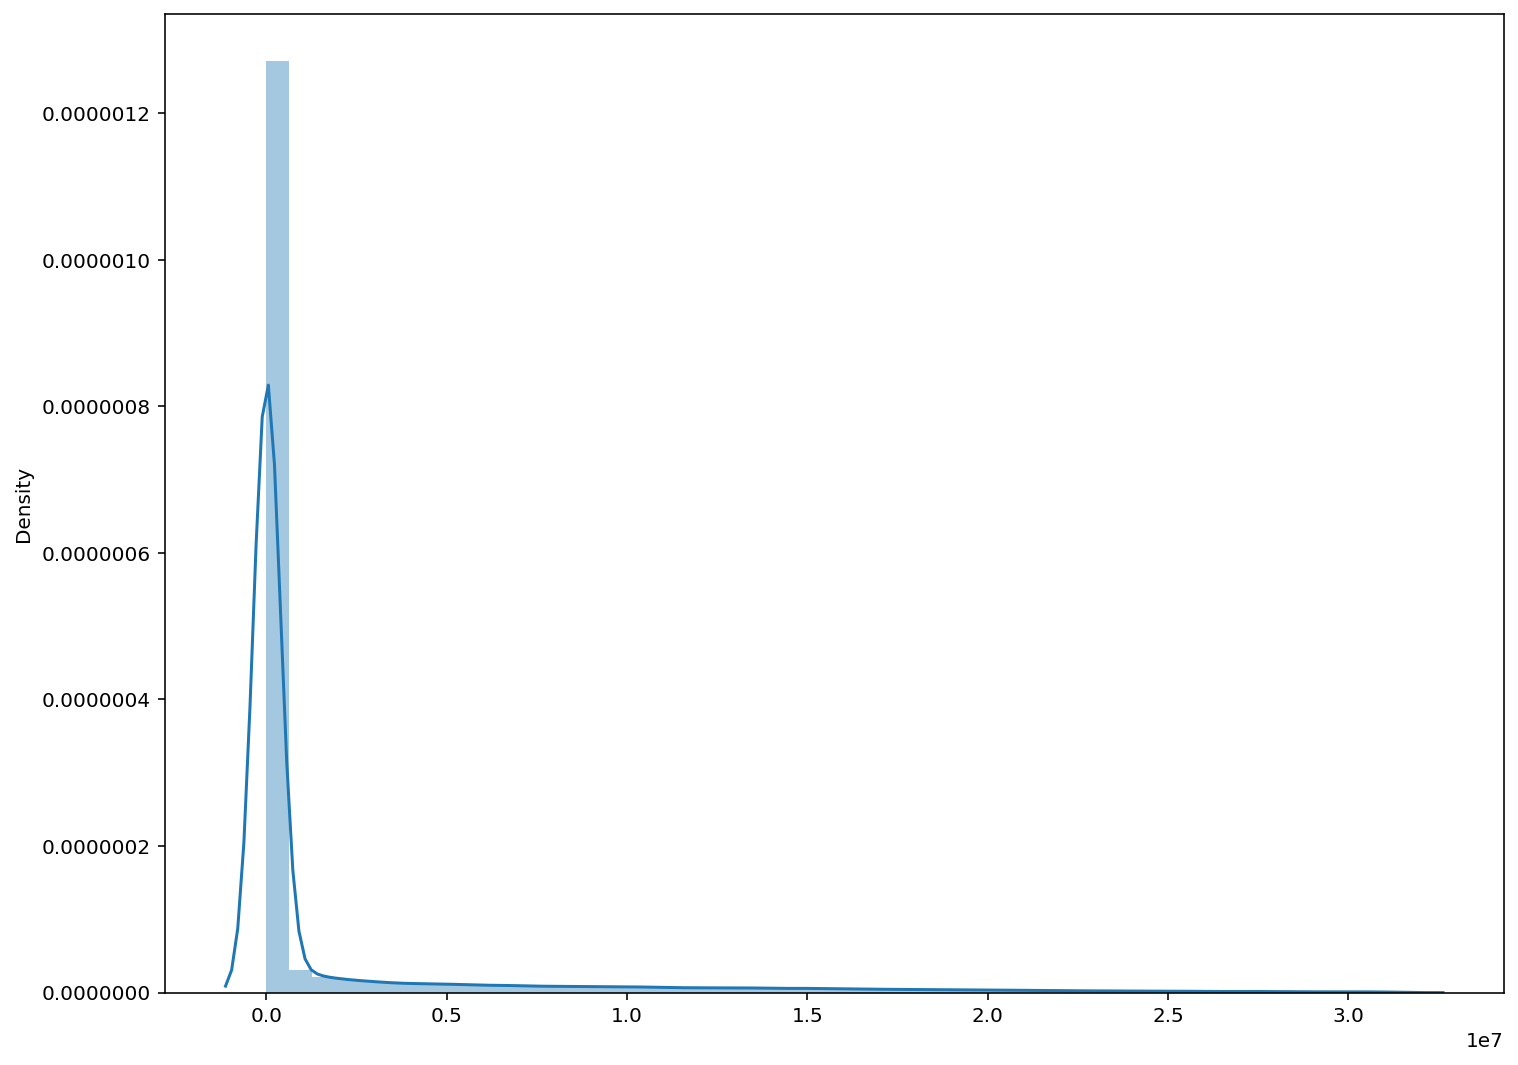

In [22]:
# Видим, что случайная величина распределена не нормально, похоже на геометрическое распределение
sns.distplot(list(all_lives));

In [23]:
print(f'В качестве lifetime примем медианное значение в секундах: {np.median(all_lives)}')
# нормируем значение на продолжительность периода наблюдений, выраженное тоже в секундах
lifetime = np.median(all_lives) / duration.total_seconds()
print(f'Значение Lifetime способом а), выраженное в долях от продолжительности наблюдений (1 год + 1,5 часа): {lifetime}')

В качестве lifetime примем медианное значение в секундах: 590.0
Значение Lifetime способом а), выраженное в долях от продолжительности наблюдений (1 год + 1,5 часа): 1.8705692278489967e-05


In [24]:
# Для когорты desktop
start_dt = visits.loc[visits.uid.isin(pure_dt)]['start_ts'].min()
end_dt   = visits.loc[visits.uid.isin(pure_dt)]['end_ts'].max()
duration_dt = end_dt - start_dt
lifetime_dt = np.median(all_lives_dt) / duration_dt.total_seconds()
# Для когорты touchscreen
start_ts = visits.loc[visits.uid.isin(pure_ts)]['start_ts'].min()
end_ts   = visits.loc[visits.uid.isin(pure_ts)]['end_ts'].max()
duration_ts = end_ts - start_ts
lifetime_ts = np.median(all_lives_ts) / duration_ts.total_seconds()
# Для когорты universals
start_un = visits.loc[visits.uid.isin(universals)]['start_ts'].min()
end_un   = visits.loc[visits.uid.isin(universals)]['end_ts'].max()
duration_un = end_un - start_un
lifetime_un = np.median(all_lives_un) / duration_un.total_seconds()

# print(lifetime_dt, lifetime_ts, lifetime_un)

Посчитаем LTV на основании полученных значений

In [25]:
LTV_1 = lifetime * arpu
print(f"В течение периода наблюдения (год + 1,5 часа) пользователь в среднем пробудет с нами " + \
      f"{np.median(all_lives)} сек. и принесет {round(arpu, 2)} у.е. дохода.")
print(f"LTV за весь период наблюдений составляет: {LTV_1:.6f} у.е.")

В течение периода наблюдения (год + 1,5 часа) пользователь в среднем пробудет с нами 590.0 сек. и принесет 0.98 у.е. дохода.
LTV за весь период наблюдений составляет: 0.000018 у.е.


In [26]:
LTV_1_dt = lifetime_dt * arpu_dt
print(f"{LTV_1_dt:.6f} у.е.")
LTV_1_ts = lifetime_ts * arpu_ts
print(f"{LTV_1_ts:.6f} у.е.")
LTV_1_un = lifetime_un * arpu_un
print(f"{LTV_1_un:.6f} у.е.")

0.000020 у.е.
0.000004 у.е.
1.007824 у.е.


Если считать Lifetime способом б):

Нужно определить период неактивности (сколько мы готовы ждать до признания, что пользователь уже не вернется, если сегодня например он не посетил приложение/сайт.)

In [27]:
# возьмем всех пользователей, которые заходили больше 1 раза
visits_grouped_by_uid = visits.groupby('uid').start_ts_unixtime.count().copy()
visits_gt_one = visits_grouped_by_uid[visits_grouped_by_uid > 1]
visits_gt_one_sorted_by_start_ts_unixtime = visits.loc[visits.uid.isin(visits_gt_one.index)].\
sort_values('start_ts_unixtime')
visits_gt_one_sorted_by_start_ts_unixtime

,device,end_ts,source_id,start_dt,start_ts,uid,idx,end_ts_unixtime,start_ts_unixtime
514579,touch,2016-06-01 00:21:28+00:00,1,2016-06-01,2016-06-01 00:01:46+00:00,1862659328,514579,1.464740e+09,1.464739e+09
49605,touch,2016-06-01 00:07:00+00:00,5,2016-06-01,2016-06-01 00:03:21+00:00,2238085368,49605,1.464740e+09,1.464739e+09
25696,desktop,2016-06-01 00:07:14+00:00,2,2016-06-01,2016-06-01 00:04:17+00:00,2274425496,25696,1.464740e+09,1.464739e+09
214048,desktop,2016-06-01 01:21:48+00:00,3,2016-06-01,2016-06-01 00:12:15+00:00,1040914197,214048,1.464744e+09,1.464740e+09
707148,touch,2016-06-01 00:25:26+00:00,1,2016-06-01,2016-06-01 00:16:32+00:00,2059458059,707148,1.464741e+09,1.464740e+09
...,...,...,...,...,...,...,...,...,...
140733,touch,2017-06-01 00:13:52+00:00,10,2017-05-31,2017-05-31 23:56:58+00:00,3214071571,140733,1.496276e+09,1.496275e+09
720380,desktop,2017-06-01 00:01:20+00:00,2,2017-05-31,2017-05-31 23:57:11+00:00,2247846247,720380,1.496275e+09,1.496275e+09
415553,desktop,2017-06-01 00:00:47+00:00,5,2017-05-31,2017-05-31 23:58:14+00:00,757394299,415553,1.496275e+09,1.496275e+09
710095,desktop,2017-06-01 00:01:34+00:00,5,2017-05-31,2017-05-31 23:58:14+00:00,757394299,710095,1.496275e+09,1.496275e+09


In [28]:
# найдем индексы самых поздних визитов 
max_idxs = list(visits_gt_one_sorted_by_start_ts_unixtime[['uid', 'start_ts_unixtime', 'idx']].\
                groupby(['uid']).last().idx)
# исключим их из выборки и найдем предыдущиме визиты
visits_gt_one_sorted_by_start_ts_unixtime_without_initial_max = \
                    visits_gt_one_sorted_by_start_ts_unixtime.query(f"index not in {max_idxs}")
max_idxs_after = list(visits_gt_one_sorted_by_start_ts_unixtime_without_initial_max[['uid', 'start_ts_unixtime', 'idx']].\
                      sort_values('start_ts_unixtime').groupby(['uid']).last().idx)
# проверим, что множества индексов не пересекаются
assert(len(max_idxs)+len(max_idxs_after) == len(set(max_idxs) | set(max_idxs_after)))
# проверим, что множества uid совпадают
assert((set(list(visits[visits.idx.isin(max_idxs)].uid.sort_values())) - \
       set(list(visits[visits.idx.isin(max_idxs_after)].uid.sort_values()))) == set())
# проверим, все ли значения unix-времени из второй выборки поэлементно больше значений из первой выборки
assert(np.sum(np.array(visits[visits.idx.isin(max_idxs)].sort_values('uid').start_ts_unixtime) >= \
       np.array(visits[visits.idx.isin(max_idxs_after)].sort_values('uid').start_ts_unixtime)) == len(max_idxs))

In [29]:
# находим длительность интервала между последним и предспоследним визитом
last_visit = np.array(visits[visits.idx.isin(max_idxs)].sort_values('uid').start_ts_unixtime).reshape(-1,1) -\
np.array(visits[visits.idx.isin(max_idxs_after)].sort_values('uid').start_ts_unixtime).reshape(-1,1)
last_visit

array([[ 450454.],
       [1971519.],
       [  79300.],
       ...,
       [2019846.],
       [6992555.],
       [ 230290.]])

In [30]:
# Для когорты desktop
last_visit_dt = np.array(visits.loc[visits.uid.isin(pure_dt)][visits.idx.isin(max_idxs)].sort_values('uid').start_ts_unixtime).reshape(-1,1) -\
np.array(visits.loc[visits.uid.isin(pure_dt)][visits.idx.isin(max_idxs_after)].sort_values('uid').start_ts_unixtime).reshape(-1,1)
# Для когорты touchscreen
last_visit_ts = np.array(visits.loc[visits.uid.isin(pure_ts)][visits.idx.isin(max_idxs)].sort_values('uid').start_ts_unixtime).reshape(-1,1) -\
np.array(visits.loc[visits.uid.isin(pure_ts)][visits.idx.isin(max_idxs_after)].sort_values('uid').start_ts_unixtime).reshape(-1,1)
# Для когорты universals
last_visit_un = np.array(visits.loc[visits.uid.isin(universals)][visits.idx.isin(max_idxs)].sort_values('uid').start_ts_unixtime).reshape(-1,1) -\
np.array(visits.loc[visits.uid.isin(universals)][visits.idx.isin(max_idxs_after)].sort_values('uid').start_ts_unixtime).reshape(-1,1)

Посмотрим на распределение случайной величины - интервал времени между последним и предспоследним визитом

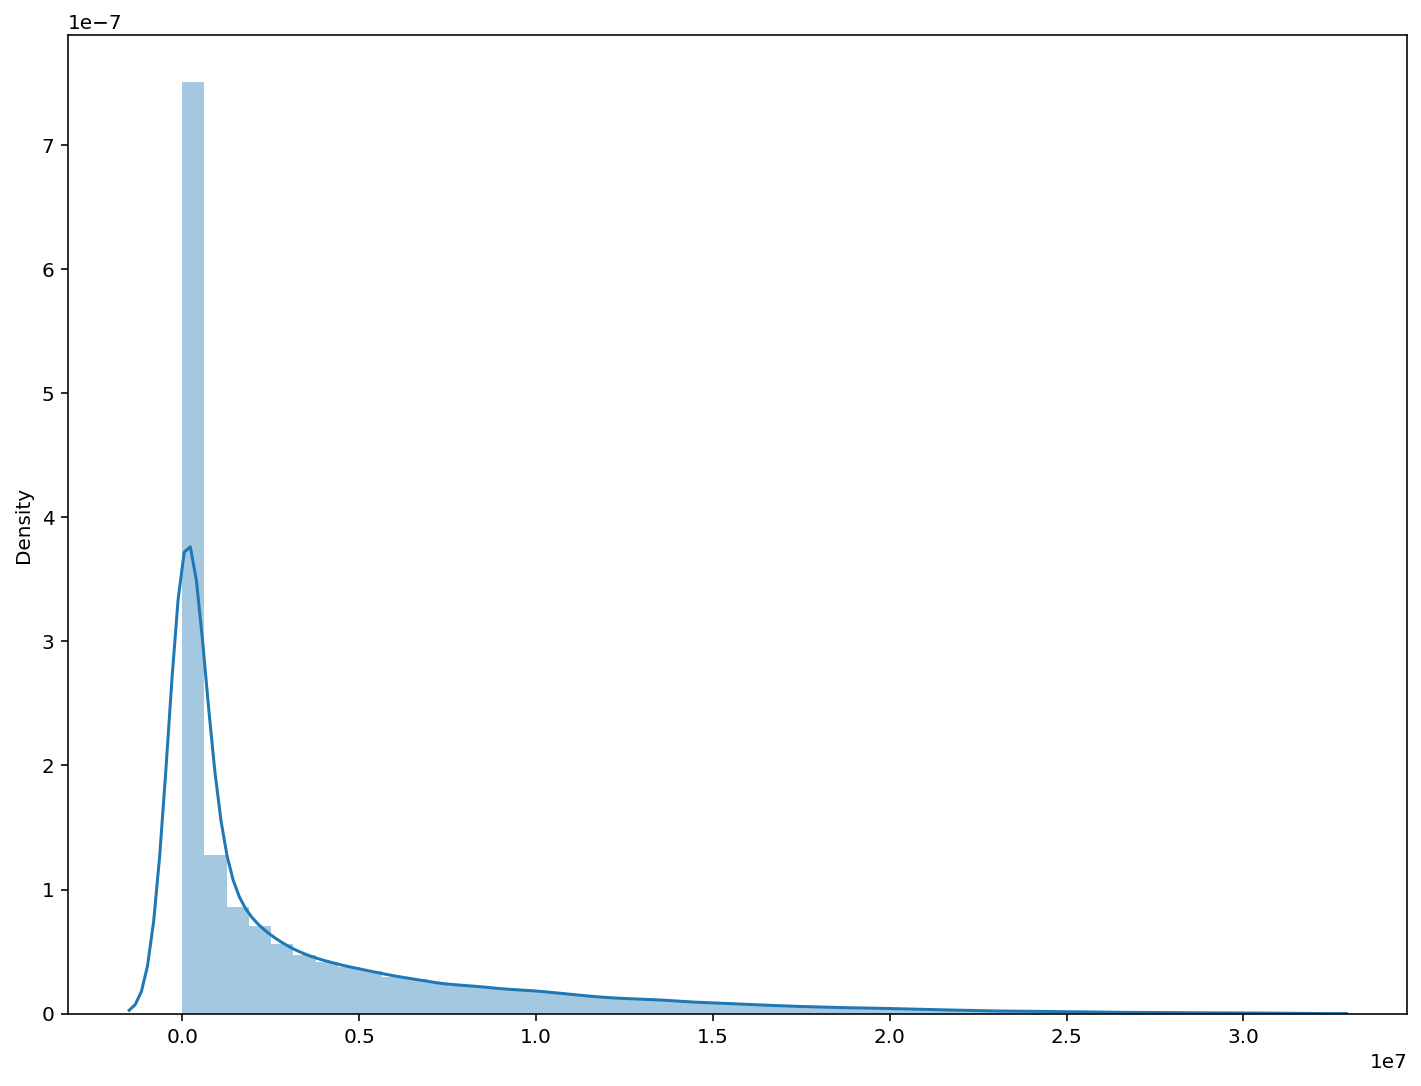

In [31]:
sns.distplot(last_visit);

In [32]:
# примем для себя, что мы готовы считать клиента активным в течение такого количества времени:
inactivity_per_sec = np.median(last_visit)
print(f'Период неактивности, после которого пользователь скорее всего не вернется: ' + 
      f'{round(inactivity_per_sec/60/60/24, 2)} дней')

Период неактивности, после которого пользователь скорее всего не вернется: 9.48 дней


In [33]:
print("Lifetime:", np.median(all_lives+inactivity_per_sec)/60/60/24, "дней")

Lifetime: 9.49048611111111 дней


In [34]:
# Для когорты desktop
inactivity_per_sec_dt = np.median(last_visit_dt)
# Для когорты touchscreen
inactivity_per_sec_ts = np.median(last_visit_ts)
# Для когорты universals
inactivity_per_sec_un = np.median(last_visit_un)

In [35]:
# Получим значение Lifetime, выраженное в долях периода наблюдений (год + 1,5 часа)
lifetime_ = np.median(all_lives+inactivity_per_sec) / duration.total_seconds()
lifetime_

0.025997044310392618

In [36]:
# Для когорты desktop
lifetime_dt_ = np.median(all_lives_dt+inactivity_per_sec_dt) / duration_dt.total_seconds()
# Для когорты touchscreen
lifetime_ts_ = np.median(all_lives_ts+inactivity_per_sec_ts) / duration_ts.total_seconds()
# Для когорты universals
lifetime_un_ = np.median(all_lives_un+inactivity_per_sec_un) / duration_un.total_seconds()
print(lifetime_dt_, lifetime_ts_, lifetime_un_)

0.0228616731493636 0.01796624846018848 0.31331385155473207


Посчитаем LTV на основании полученных значений

In [37]:
LTV_2 = lifetime_ * arpu

print(f"В течение периода наблюдения (год + 1,5 часа) пользователь в среднем пробудет с нами " + \
      f"{np.median(all_lives+inactivity_per_sec)} сек. и принесет {round(arpu, 2)} у.е. дохода.")
print(f"LTV за весь период наблюдений составляет: {LTV_2:.6f} у.е.")

В течение периода наблюдения (год + 1,5 часа) пользователь в среднем пробудет с нами 819978.0 сек. и принесет 0.98 у.е. дохода.
LTV за весь период наблюдений составляет: 0.025361 у.е.


Такой низкий результат связан с тем, что в ARPU в знаменатель попали все уникальные пользователи, т.к. за год они все были активны.

In [38]:
# Для когорты desktop
LTV_2_dt = lifetime_dt_ * arpu_dt
print(f"{LTV_2_dt:.6f} у.е.")
# Для когорты touchscreen
LTV_2_ts = lifetime_ts * arpu_ts
print(f"{LTV_2_ts:.6f} у.е.")
# Для когорты universals
LTV_2_un = lifetime_un_ * arpu_un
print(f"{LTV_2_un:.6f} у.е.")

0.023486 у.е.
0.000004 у.е.
1.235015 у.е.


Считаем ARPU помесячно: для вариантов а) и б) расчета Lifetime и для каждой когорты

In [39]:
# соберем списки объектов datetime - начала и окончания периодов наблюдения (начало i-го месяца -> начало i+1-го месяца )  
start_month_list, end_month_list = [], []
s_year, s_month = start.year, start.month

for i in range(1,14):
    s = datetime(year=s_year, month=s_month, day=1)
    days = calendar.monthrange(s_year, s_month)[1]
    e = s + timedelta(days=days)
    s_year = e.year
    s_month = e.month
    start_month_list.append(s)
    end_month_list.append(e)

#####
total_active_users_list_ = []
new_active_users_list_ = []
unique_users_list_ = []
new_users_list_ = []
ltv_month_list_ = []
lifetime_b_month_list_ = []
arpu_month_list_ = []

kogorts_df_dict = {'all':[visits.copy(), purchases.copy()], 
                   'pure_dt':[visits.copy().loc[visits.uid.isin(pure_dt)], 
                              purchases.copy().loc[purchases.uid.isin(pure_dt)]], 
                   'pure_ts':[visits.copy().loc[visits.uid.isin(pure_ts)], 
                              purchases.copy().loc[purchases.uid.isin(pure_ts)]], 
                   'universals':[visits.copy().loc[visits.uid.isin(universals)], 
                                 purchases.copy().loc[purchases.uid.isin(universals)]]}
kogorts_df_list = ['all', 'pure_dt', 'pure_ts', 'universals']

for k in kogorts_df_list:
    print('\n', '*'*5, f'Расчет для когорты {k}', '*'*5)
    # Всего активных пользователей (новых и старых) с точки зрения периода неактивности (inactivity_per_sec) к концу месяца
    total_active_users_list, total_active_users_set = [], set()

    # Всего новых активных пользователей с точки зрения периода неактивности (inactivity_per_sec) к концу месяца
    new_active_users_list = []
    # Общее количество уникальных пользователей (активных и неактивных) к концу месяца
    unique_users_list, unique_users_set = [], set()
    # Количество уникальных новых пользователей (активных и неактивных) к концу месяца
    new_users_list, new_users_set = [], set()

    #######
    ltv_month_list = []
    lifetime_b_month_list = []
    arpu_month_list = []


    # для каждого месяца
    for sm, em in zip(start_month_list, end_month_list):
        # фильтруем датафрейм по визитам не позже конца месяца (начало проекта - конец месяца)
        visits_1 = kogorts_df_dict[k][0][kogorts_df_dict[k][0].end_ts_unixtime < em.timestamp()].copy()

        # фильтруем датафрейм по визитам не позже конца месяца и не раньше начала месяца  (начало месяца - конец месяца)
        visits_2 = kogorts_df_dict[k][0][(kogorts_df_dict[k][0].end_ts_unixtime < em.timestamp()) & (kogorts_df_dict[k][0].end_ts_unixtime >= sm.timestamp())].copy()

        # фильтруем полученный датафрейм по визитам не позже конца месяца минус период неактивности (20-30 числа месяца)
        visits_3 = visits_1[visits_1.end_ts_unixtime >= (em.timestamp() - inactivity_per_sec)].copy()

        ####
        purchases_1 = kogorts_df_dict[k][1][kogorts_df_dict[k][1].buy_ts_unixtime < em.timestamp()].copy()

        # уникальные пользователи (накопительным итогом)
        unique_users_set = unique_users_set | set(visits_1.uid)
        unique_users_list.append(len(unique_users_set))
        # пользователи, пришедшие в текущем месяце
        new_users_set = unique_users_set & set(visits_2.uid)
        new_users_list.append(len(new_users_set))
        # все активные пользователи (накопительным итогом)
        total_active_users_set = total_active_users_set | set(visits_3.uid)
        total_active_users_list.append(len(total_active_users_set))
        # пользователи, пришедшие в текущем месяце, которые к концу месяца считаются нами активными
        new_active_users_set = new_users_set & set(visits_3.uid)
        new_active_users_list.append(len(new_active_users_set))


        #### inactivity
        visits_grouped_by_uid = visits_1.groupby('uid').start_ts_unixtime.count()
        visits_gt_one = visits_grouped_by_uid[visits_grouped_by_uid > 1]
        visits_gt_one_sorted_by_start_ts_unixtime = visits_1.loc[visits_1.uid.isin(visits_gt_one.index)].sort_values('start_ts_unixtime')
        max_idxs = list(visits_gt_one_sorted_by_start_ts_unixtime[['uid', 'start_ts_unixtime', 'idx']].groupby(['uid']).last().idx)
        visits_gt_one_sorted_by_start_ts_unixtime_without_initial_max = \
        visits_gt_one_sorted_by_start_ts_unixtime.query(f"index not in {max_idxs}")
        max_idxs_after = list(visits_gt_one_sorted_by_start_ts_unixtime_without_initial_max[['uid', 'start_ts_unixtime', 'idx']].sort_values('start_ts_unixtime').groupby(['uid']).last().idx)
        last_visit = np.array(visits_1[visits_1.idx.isin(max_idxs)].sort_values('uid').start_ts_unixtime).reshape(-1,1) -\
        np.array(visits_1[visits_1.idx.isin(max_idxs_after)].sort_values('uid').start_ts_unixtime).reshape(-1,1)
        inactivity_per_sec = np.median(last_visit)

        #### вычислим duration (продолжительность наблюдений)
        start = visits_1['start_ts'].min()
        end = visits_1['end_ts'].max()
        duration = end - start
        
        #### вычислим lifetime обоими способами
        start_lt = visits_1[['uid', 'start_ts_unixtime']].groupby('uid').min().sort_values(by=['uid'])
        end_lt   = visits_1[['uid', 'end_ts_unixtime']].groupby('uid').max().sort_values(by=['uid'])
        all_lives = end_lt.end_ts_unixtime - start_lt.start_ts_unixtime
        lifetime_a = np.median(all_lives) / duration.total_seconds()
        lifetime_b = (np.median(all_lives) + inactivity_per_sec) / duration.total_seconds()
        
        # вычислим основные показатели и соберем их в списки
        total_revenue = purchases_1.revenue.sum()
        active_users = visits_3.uid.unique() 
        arpu = total_revenue/active_users.shape[0]
        ltv = lifetime_b * arpu
        print(f"date: {sm} | LTV: {ltv:.6f} | lifetime_a: {lifetime_a:.6f} | lifetime_b: {lifetime_b:.6f} | arpu: {arpu:.6f}")
        ltv_month_list.append(ltv)
        lifetime_b_month_list.append(lifetime_b)
        arpu_month_list.append(arpu)

    
    total_active_users_list_.append(total_active_users_list)
    new_active_users_list_.append(new_active_users_list)
    unique_users_list_.append(unique_users_list)
    new_users_list_.append(new_users_list)
    ltv_month_list_.append(ltv_month_list)
    lifetime_b_month_list_.append(lifetime_b_month_list)
    arpu_month_list_.append(arpu_month_list)


 ***** Расчет для когорты all *****
date: 2016-06-01 00:00:00 | LTV: 0.197557 | lifetime_a: 0.000168 | lifetime_b: 0.033268 | arpu: 5.938337
date: 2016-07-01 00:00:00 | LTV: 2.420363 | lifetime_a: 0.000087 | lifetime_b: 0.032838 | arpu: 73.705417
date: 2016-08-01 00:00:00 | LTV: 1.196493 | lifetime_a: 0.000058 | lifetime_b: 0.032634 | arpu: 36.663511
date: 2016-09-01 00:00:00 | LTV: 0.617011 | lifetime_a: 0.000045 | lifetime_b: 0.030179 | arpu: 20.444744
date: 2016-10-01 00:00:00 | LTV: 0.477454 | lifetime_a: 0.000038 | lifetime_b: 0.026773 | arpu: 17.833456
date: 2016-11-01 00:00:00 | LTV: 0.432506 | lifetime_a: 0.000034 | lifetime_b: 0.023504 | arpu: 18.401704
date: 2016-12-01 00:00:00 | LTV: 0.594430 | lifetime_a: 0.000030 | lifetime_b: 0.024318 | arpu: 24.444091
date: 2017-01-01 00:00:00 | LTV: 0.591703 | lifetime_a: 0.000027 | lifetime_b: 0.025661 | arpu: 23.058896
date: 2017-02-01 00:00:00 | LTV: 0.550239 | lifetime_a: 0.000024 | lifetime_b: 0.025754 | arpu: 21.365039
date: 2017

In [40]:
print(f"Значение lifetime_a из последнего ('короткого') месяца совпало с ранее рассчитанным и составило: {590/(60*60*24*365):.6f}")

Значение lifetime_a из последнего ('короткого') месяца совпало с ранее рассчитанным и составило: 0.000019


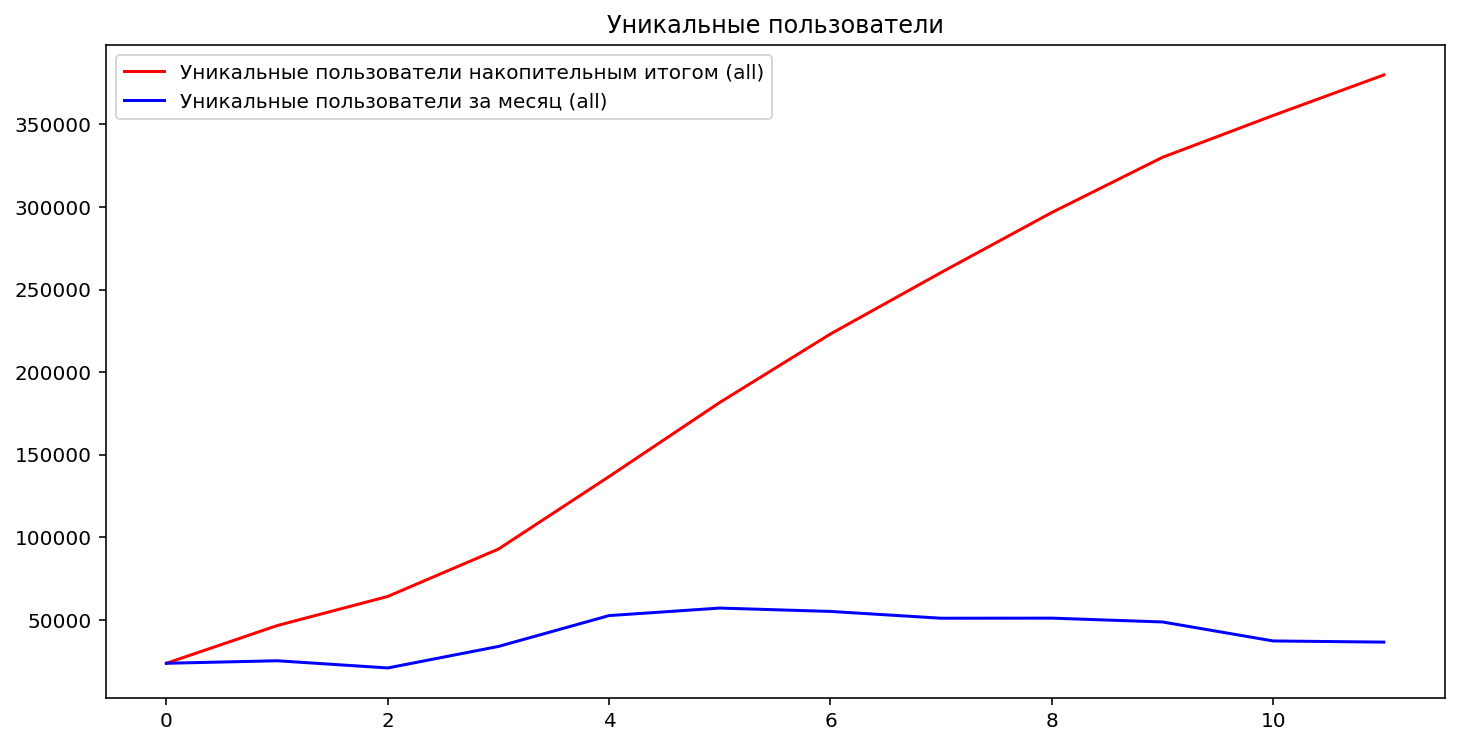

In [41]:
x = list(range(len(unique_users_list_[0][:-1])))
y_1 = unique_users_list_[0][:-1]
y_2 = new_users_list_[0][:-1]

fig, ax = plt.subplots()

ax.plot(x, y_1, label="Уникальные пользователи накопительным итогом (all)", c='red')
ax.plot(x, y_2, label="Уникальные пользователи за месяц (all)", c='blue')

ax.set_title("Уникальные пользователи")
ax.legend()

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

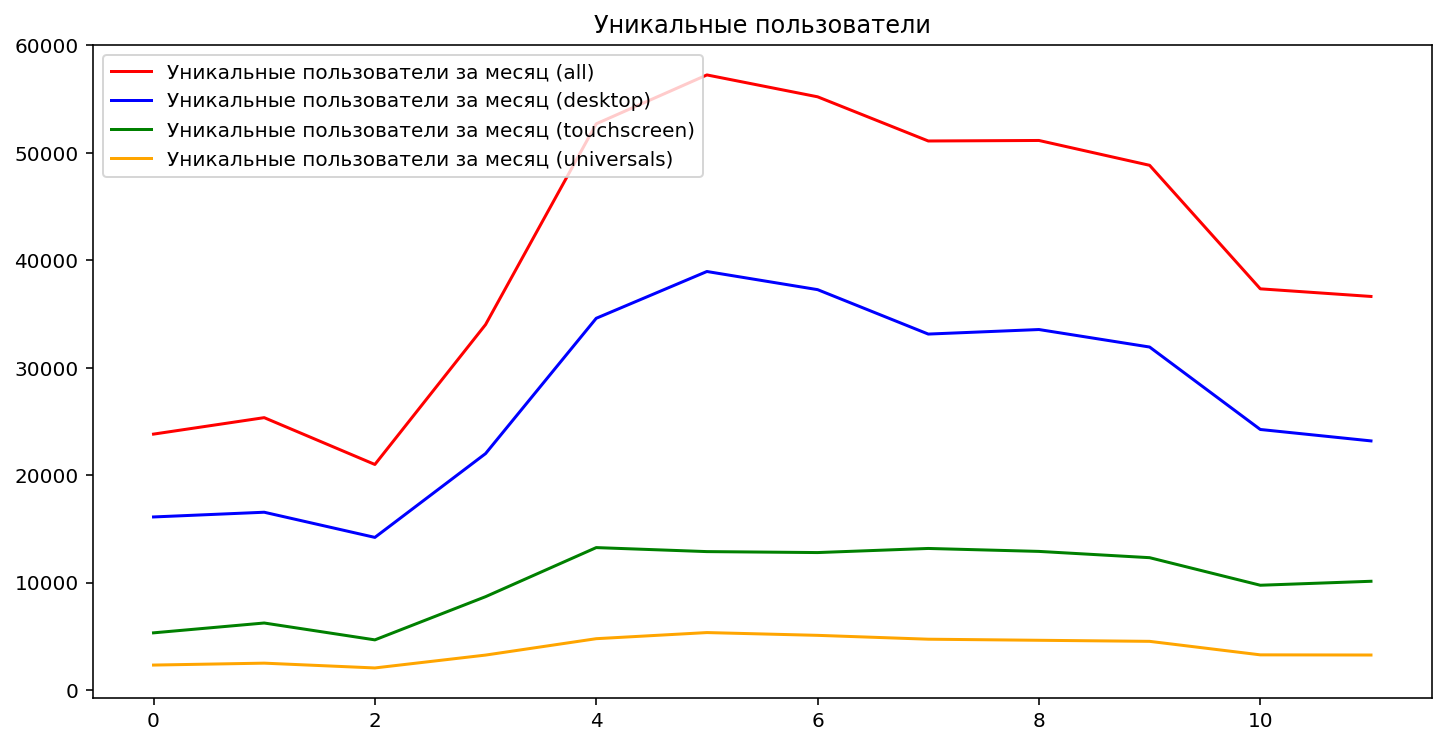

In [42]:
x = list(range(len(unique_users_list_[0][:-1])))
y_2 = new_users_list_[0][:-1]
y_4 = new_users_list_[1][:-1]
y_6 = new_users_list_[2][:-1]
y_8 = new_users_list_[3][:-1]

fig, ax = plt.subplots()

ax.plot(x, y_2, label="Уникальные пользователи за месяц (all)", c='red')
ax.plot(x, y_4, label="Уникальные пользователи за месяц (desktop)", c='blue')
ax.plot(x, y_6, label="Уникальные пользователи за месяц (touchscreen)", c='green')
ax.plot(x, y_8, label="Уникальные пользователи за месяц (universals)", c='orange')

ax.set_title("Уникальные пользователи")
ax.legend()

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

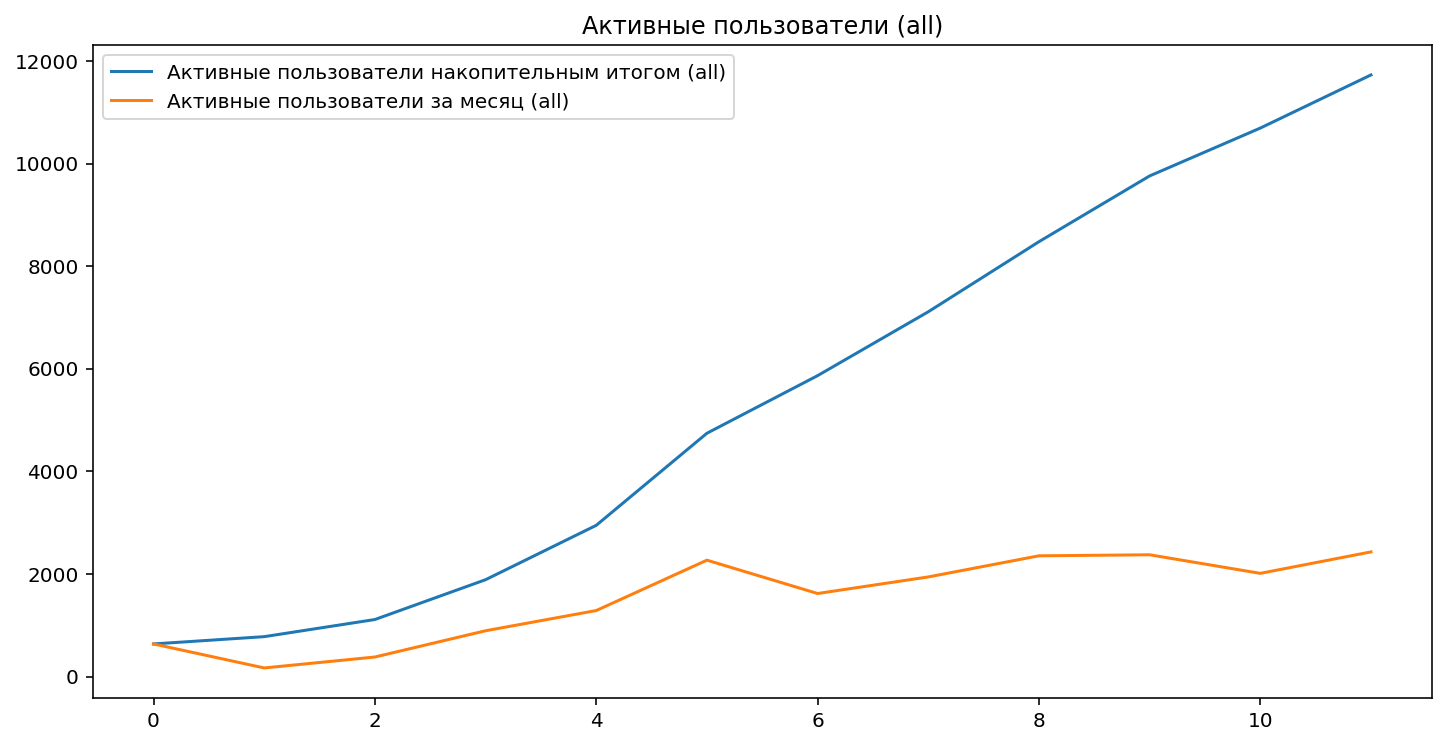

In [43]:
x = list(range(len(total_active_users_list[:-1])))
y_1 = total_active_users_list[:-1]
y_2 = new_active_users_list[:-1]

fig, ax = plt.subplots()

ax.plot(x, y_1, label="Активные пользователи накопительным итогом (all)")
ax.plot(x, y_2, label="Активные пользователи за месяц (all)")
ax.set_title("Активные пользователи (all)")
ax.legend()

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

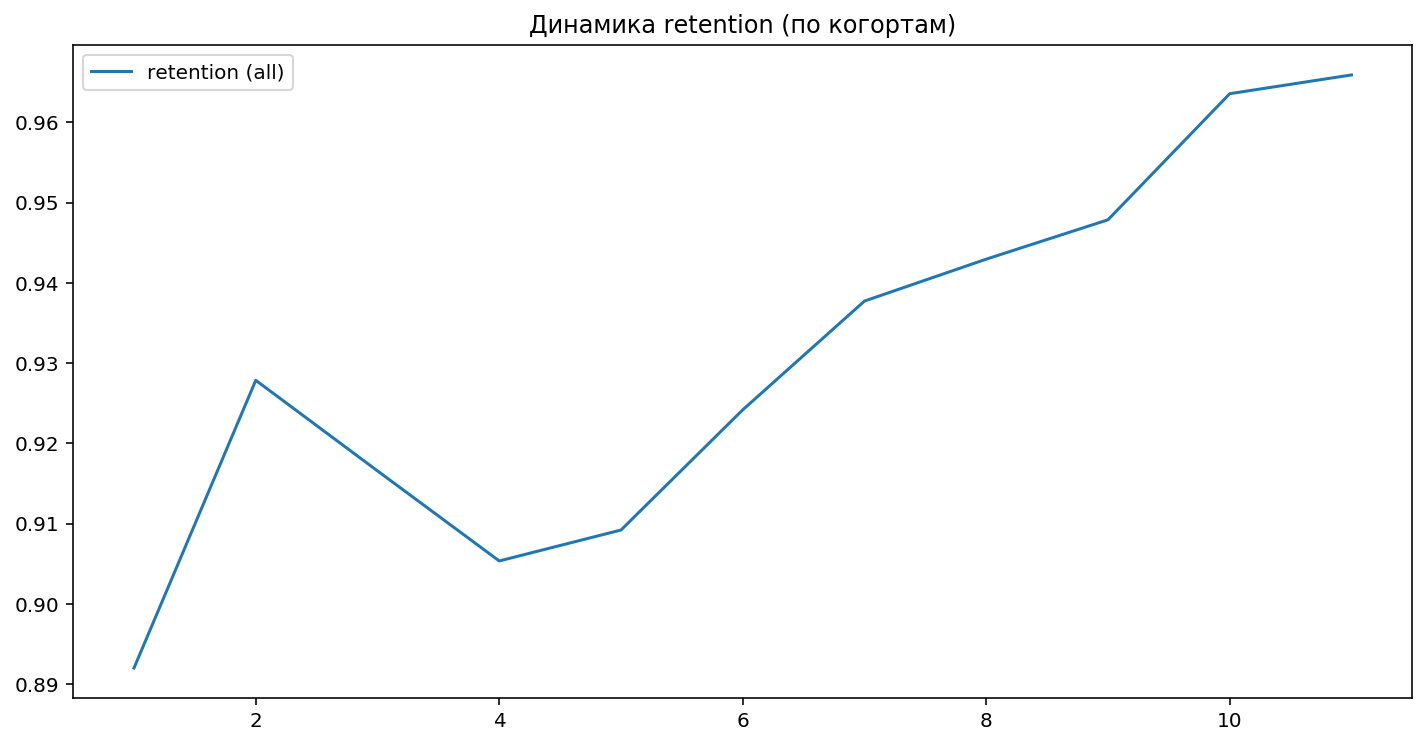

In [44]:
def retention(unique_users_arr, new_users_arr, draw=True, nans=False):
    """
    Коэффициент удержания клиентов (retention) = ((Количество клиентов в конце периода — Количество клиентов, 
    приобретенных в течение периода) / Количество клиентов в начале периода) X 100%
    """
    init_unique_users_arr = np.insert(unique_users_arr, 0, 0)[:-1].reshape(-1,1)
    assert(unique_users_arr.shape[1] == new_users_arr.shape[1] \
           == init_unique_users_arr.shape[1] == 1)
    retention = (unique_users_arr - new_users_arr) / init_unique_users_arr
    if nans:
        retention = np.nan_to_num(retention, copy=True, nan=1.0, 
                                  posinf=None, neginf=None)
    if draw:
        plt.plot(retention);
    return retention

retention_arr_list = []
for uul, nul in zip(unique_users_list_, new_users_list_):
    arr_1 = np.array(uul[:-1]).reshape(-1,1)
    arr_2 = np.array(nul[:-1]).reshape(-1,1)
    retention_arr = retention(arr_1, arr_2, draw=False);
    retention_arr_list.append(retention_arr)

x = list(range(retention_arr_list[0].shape[0]))
y_1 = retention_arr_list[0]
# y_2 = retention_arr_list[1]
# y_3 = retention_arr_list[2]
# y_4 = retention_arr_list[3]

fig, ax = plt.subplots()

ax.plot(x, y_1, label="retention (all)")
# ax.plot(x, y_2, label="retention (desktop)")
# ax.plot(x, y_3, label="retention (touchscreen)")
# ax.plot(x, y_4, label="retention (universals)")
ax.set_title(f"Динамика retention (по когортам)")
ax.legend()

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

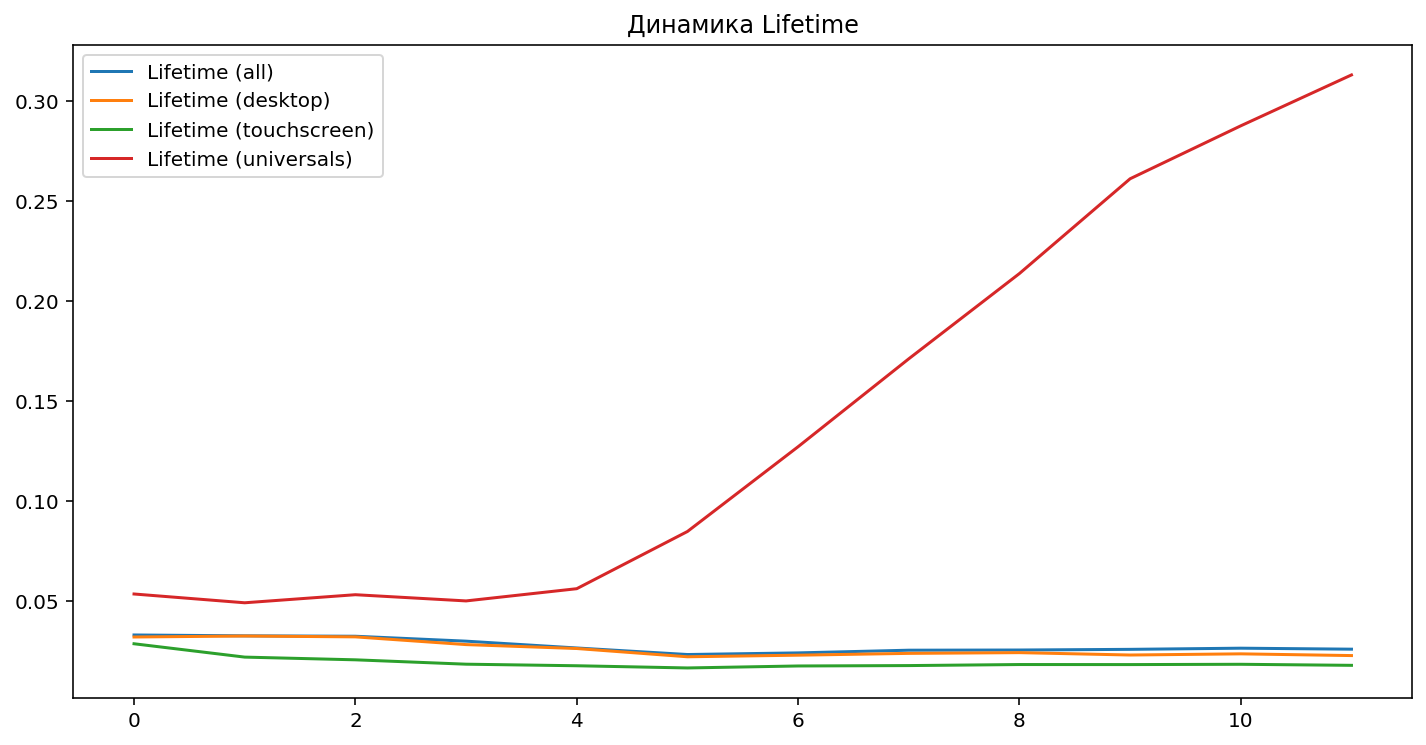

In [45]:
x = list(range(len(lifetime_b_month_list_[0][:-1])))
y_1 = lifetime_b_month_list_[0][:-1]
y_2 = lifetime_b_month_list_[1][:-1]
y_3 = lifetime_b_month_list_[2][:-1]
y_4 = lifetime_b_month_list_[3][:-1]

fig, ax = plt.subplots()

ax.plot(x, y_1, label="Lifetime (all)")
ax.plot(x, y_2, label="Lifetime (desktop)")
ax.plot(x, y_3, label="Lifetime (touchscreen)")
ax.plot(x, y_4, label="Lifetime (universals)")

ax.set_title("Динамика Lifetime")
ax.legend()

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

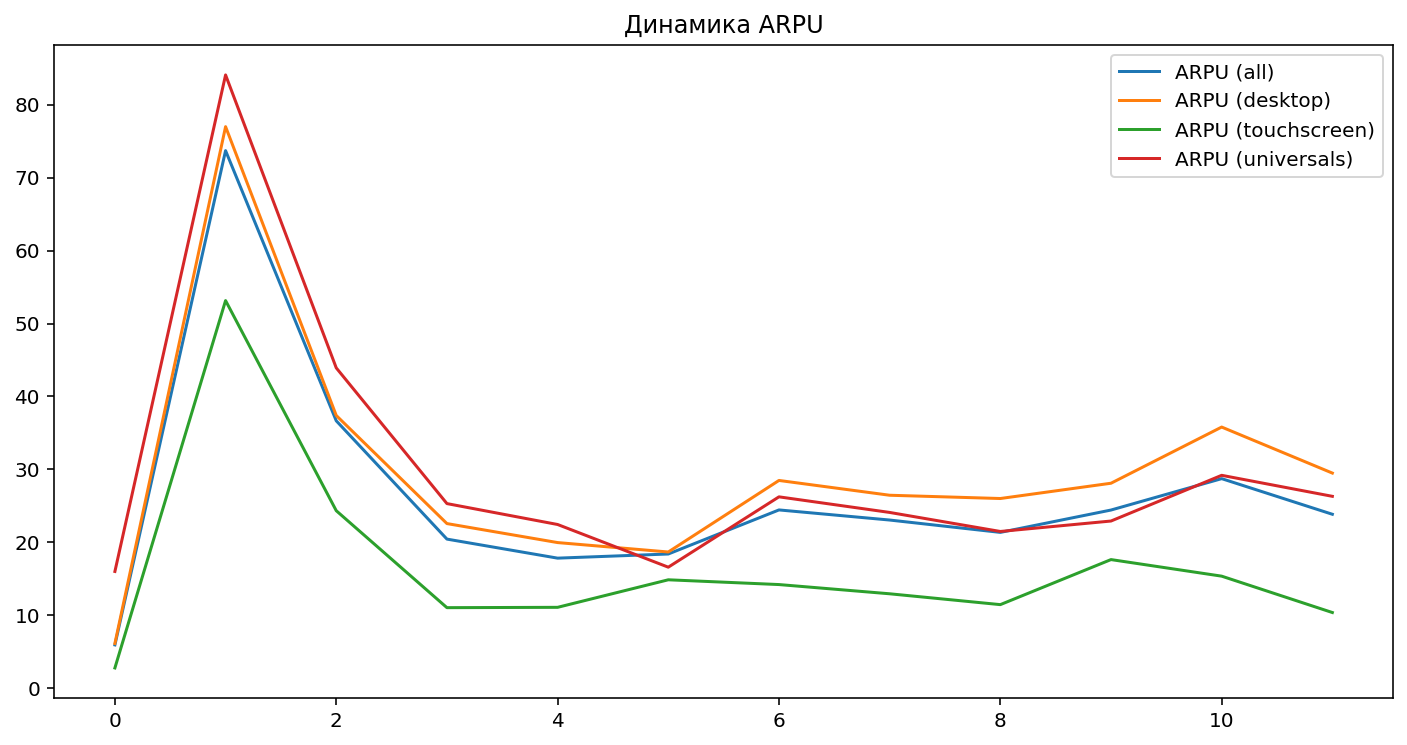

In [46]:
x = list(range(len(arpu_month_list_[0][:-1])))
y_1 = arpu_month_list_[0][:-1]
y_2 = arpu_month_list_[1][:-1]
y_3 = arpu_month_list_[2][:-1]
y_4 = arpu_month_list_[3][:-1]

fig, ax = plt.subplots()

ax.plot(x, y_1, label="ARPU (all)")
ax.plot(x, y_2, label="ARPU (desktop)")
ax.plot(x, y_3, label="ARPU (touchscreen)")
ax.plot(x, y_4, label="ARPU (universals)")

ax.set_title("Динамика ARPU")
ax.legend()

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

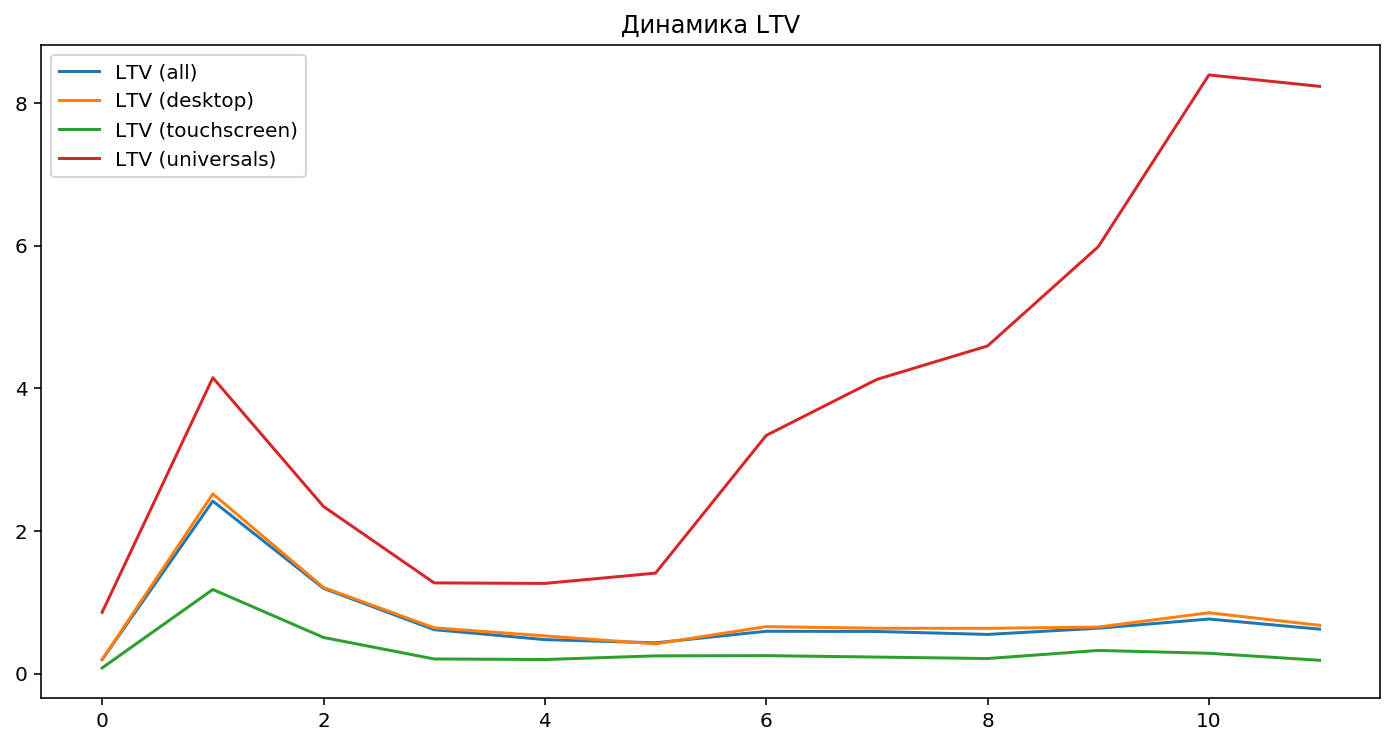

In [47]:
x = list(range(len(ltv_month_list_[0][:-1])))
y_1 = ltv_month_list_[0][:-1]
y_2 = ltv_month_list_[1][:-1]
y_3 = ltv_month_list_[2][:-1]
y_4 = ltv_month_list_[3][:-1]

fig, ax = plt.subplots()

ax.plot(x, y_1, label="LTV (all)")
ax.plot(x, y_2, label="LTV (desktop)")
ax.plot(x, y_3, label="LTV (touchscreen)")
ax.plot(x, y_4, label="LTV (universals)")
ax.set_title("Динамика LTV")
ax.legend()

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

In [48]:
s = integrate.trapz(y_1, x)
print(f"Площадь под кривой: {s}")

Площадь под кривой: 8.69457511261687


In [49]:
LTV_3 = s/len(y_1)
LTV_3

0.7245479260514059

In [50]:
# Для когорты desktop
LTV_3_dt = integrate.trapz(y_2, x)/len(y_2)
print(f"{LTV_3_dt:.6f} у.е.")
# Для когорты touchscreen
LTV_3_ts = integrate.trapz(y_3, x)/len(y_3)
print(f"{LTV_3_ts:.6f} у.е.")
# Для когорты universals
LTV_3_un = integrate.trapz(y_4, x)/len(y_4)
print(f"{LTV_3_un:.6f} у.е.")

0.766507 у.е.
0.315523 у.е.
3.452757 у.е.


***2. Сложный***:

Посчитаем средний чек AOV (Average Order Value) 

In [51]:
aov = purchases.revenue.mean()
print("AOV ", round(aov, 2), "у.е.")

AOV  4.9 у.е.


Посчитаем количество покупок для каждого uid из purchases

In [52]:
print(f"Покупающий хоть однажды клиент: в среднем совершает: {np.round(np.mean(purchases.groupby('uid').revenue.count()), 2)} покупки")
print(f"(в т.ч. благодаря покупателям, которые совершают {np.max(purchases.groupby('uid').revenue.count())} покупок)")
print(f"Медианное значение: {np.median(purchases.groupby('uid').revenue.count())}")
print(f"Мода: {statistics.mode(purchases.groupby('uid').revenue.count())}")

Покупающий хоть однажды клиент: в среднем совершает: 1.36 покупки
(в т.ч. благодаря покупателям, которые совершают 1179 покупок)
Медианное значение: 1.0
Мода: 1


Расчитаем RPR

In [53]:
rpr = purchases.groupby('uid').revenue.count().mean()
rpr

1.3570634835286948

Расчитаем LTV

In [54]:
LTV_4 = aov * rpr * lifetime_
LTV_4

0.17278662844380532

Теперь посчитаем помесячно

In [55]:
##### пустные списки для сбора списков значений по месяцам для когорт
total_active_users_list_ = []
new_active_users_list_ = []
unique_users_list_ = []
new_users_list_ = []
ltv_month_list_ = []
lifetime_b_month_list_ = []
arpu_month_list_ = []

# бежим по когортам
for k in kogorts_df_list:
    print('\n', '*'*5, f'Расчет для когорты {k}', '*'*5)

    # Всего активных пользователей (новых и старых) с точки зрения периода неактивности (inactivity_per_sec) к концу месяца
    total_active_users_list, total_active_users_set = [], set()

    # Всего новых активных пользователей с точки зрения периода неактивности (inactivity_per_sec) к концу месяца
    new_active_users_list = []
    # Общее количество уникальных пользователей (активных и неактивных) к концу месяца
    unique_users_list, unique_users_set = [], set()
    # Количество уникальных новых пользователей (активных и неактивных) к концу месяца
    new_users_list, new_users_set = [], set()

    #######
    ltv_month_list = []
    lifetime_b_month_list = []
    arpu_month_list = []
    aov_month_list = []

    # для каждого месяца
    for sm, em in zip(start_month_list, end_month_list):
        # фильтруем датафрейм по визитам не позже конца месяца (начало проекта - конец месяца)
        visits_1 = kogorts_df_dict[k][0][kogorts_df_dict[k][0].end_ts_unixtime < em.timestamp()].copy()

        # фильтруем датафрейм по визитам не позже конца месяца и не раньше начала месяца  (начало месяца - конец месяца)
        visits_2 = kogorts_df_dict[k][0][(kogorts_df_dict[k][0].end_ts_unixtime < em.timestamp()) & (kogorts_df_dict[k][0].end_ts_unixtime >= sm.timestamp())].copy()

        # фильтруем полученный датафрейм по визитам не позже конца месяца минус период неактивности (20-30 числа месяца)
        visits_3 = visits_1[visits_1.end_ts_unixtime >= (em.timestamp() - inactivity_per_sec)].copy()

        #### purchases_1
        purchases_1 = kogorts_df_dict[k][1][kogorts_df_dict[k][1].buy_ts_unixtime < em.timestamp()].copy()

        # уникальные пользователи (накопительным итогом)
        unique_users_set = unique_users_set | set(visits_1.uid)
        unique_users_list.append(len(unique_users_set))
        # пользователи, пришедшие в текущем месяце
        new_users_set = unique_users_set & set(visits_2.uid)
        new_users_list.append(len(new_users_set))
        # все активные пользователи (накопительным итогом)
        total_active_users_set = total_active_users_set | set(visits_3.uid)
        total_active_users_list.append(len(total_active_users_set))
        # пользователи, пришедшие в текущем месяце, которые к концу месяца считаются нами активными
        new_active_users_set = new_users_set & set(visits_3.uid)
        new_active_users_list.append(len(new_active_users_set))


        #### inactivity
        visits_grouped_by_uid = visits_1.groupby('uid').start_ts_unixtime.count()
        visits_gt_one = visits_grouped_by_uid[visits_grouped_by_uid > 1]
        visits_gt_one_sorted_by_start_ts_unixtime = visits_1.loc[visits_1.uid.isin(visits_gt_one.index)].sort_values('start_ts_unixtime')
        max_idxs = list(visits_gt_one_sorted_by_start_ts_unixtime[['uid', 'start_ts_unixtime', 'idx']].groupby(['uid']).last().idx)
        visits_gt_one_sorted_by_start_ts_unixtime_without_initial_max = \
        visits_gt_one_sorted_by_start_ts_unixtime.query(f"index not in {max_idxs}")
        max_idxs_after = list(visits_gt_one_sorted_by_start_ts_unixtime_without_initial_max[['uid', 'start_ts_unixtime', 'idx']].sort_values('start_ts_unixtime').groupby(['uid']).last().idx)
        last_visit = np.array(visits_1[visits_1.idx.isin(max_idxs)].sort_values('uid').start_ts_unixtime).reshape(-1,1) -\
        np.array(visits_1[visits_1.idx.isin(max_idxs_after)].sort_values('uid').start_ts_unixtime).reshape(-1,1)
        inactivity_per_sec = np.median(last_visit)

        #### duration
        start = visits_1['start_ts'].min()
        end = visits_1['end_ts'].max()
        duration = end - start

        start_lt = visits_1[['uid', 'start_ts_unixtime']].groupby('uid').min().sort_values(by=['uid'])
        end_lt   = visits_1[['uid', 'end_ts_unixtime']].groupby('uid').max().sort_values(by=['uid'])
        all_lives = end_lt.end_ts_unixtime - start_lt.start_ts_unixtime
        lifetime_a = np.median(all_lives) / duration.total_seconds()
        lifetime_b = (np.median(all_lives) + inactivity_per_sec) / duration.total_seconds()

        #### aov
        aov = purchases_1.revenue.mean()
        rpr = purchases_1.groupby('uid').revenue.count().mean()

        total_revenue = purchases_1.revenue.sum()
        active_users = visits_3.uid.unique() 
        arpu = total_revenue/active_users.shape[0]
        ltv = aov * rpr * lifetime_b
        print(f"date: {sm} | LTV: {ltv:.6f} | lifetime_b: {lifetime_b:.6f} | aov: {aov:.6f} | rpr: {rpr:.6f}")
        ltv_month_list.append(ltv)
        lifetime_b_month_list.append(lifetime_b)
        arpu_month_list.append(arpu)
    
    total_active_users_list_.append(total_active_users_list)
    new_active_users_list_.append(new_active_users_list)
    unique_users_list_.append(unique_users_list)
    new_users_list_.append(new_users_list)
    ltv_month_list_.append(ltv_month_list)
    lifetime_b_month_list_.append(lifetime_b_month_list)
    arpu_month_list_.append(arpu_month_list)


 ***** Расчет для когорты all *****
date: 2016-06-01 00:00:00 | LTV: 0.180443 | lifetime_b: 0.033268 | aov: 4.575593 | rpr: 1.185401
date: 2016-07-01 00:00:00 | LTV: 0.183140 | lifetime_b: 0.032838 | aov: 4.646989 | rpr: 1.200136
date: 2016-08-01 00:00:00 | LTV: 0.185612 | lifetime_b: 0.032634 | aov: 4.674833 | rpr: 1.216644
date: 2016-09-01 00:00:00 | LTV: 0.181148 | lifetime_b: 0.030179 | aov: 4.837636 | rpr: 1.240766
date: 2016-10-01 00:00:00 | LTV: 0.170101 | lifetime_b: 0.026773 | aov: 5.030594 | rpr: 1.262968
date: 2016-11-01 00:00:00 | LTV: 0.152277 | lifetime_b: 0.023504 | aov: 5.005943 | rpr: 1.294240
date: 2016-12-01 00:00:00 | LTV: 0.159545 | lifetime_b: 0.024318 | aov: 5.019992 | rpr: 1.306937
date: 2017-01-01 00:00:00 | LTV: 0.166490 | lifetime_b: 0.025661 | aov: 4.939479 | rpr: 1.313533
date: 2017-02-01 00:00:00 | LTV: 0.167438 | lifetime_b: 0.025754 | aov: 4.911207 | rpr: 1.323787
date: 2017-03-01 00:00:00 | LTV: 0.171372 | lifetime_b: 0.026086 | aov: 4.916046 | rpr: 1.

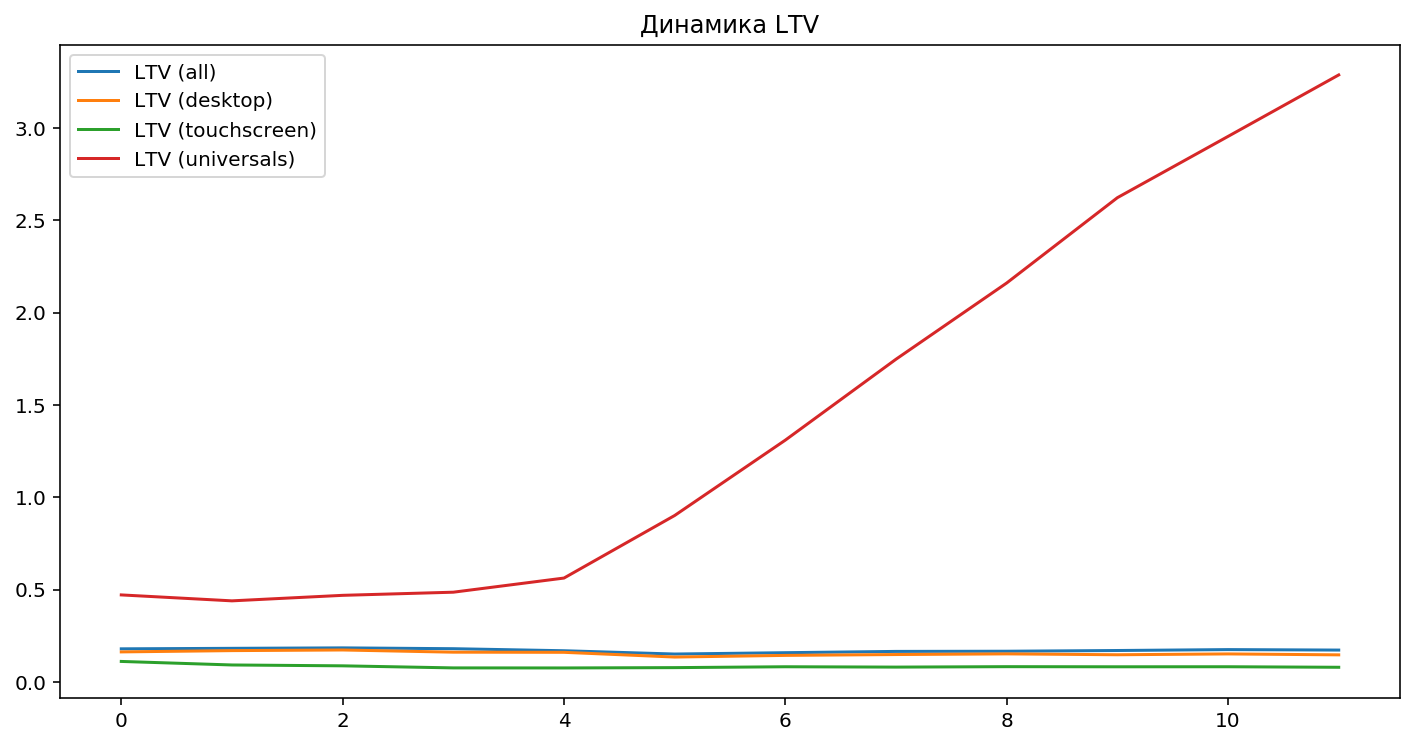

In [56]:
x = list(range(len(ltv_month_list_[0][:-1])))
y_1 = ltv_month_list_[0][:-1]
y_2 = ltv_month_list_[1][:-1]
y_3 = ltv_month_list_[2][:-1]
y_4 = ltv_month_list_[3][:-1]

fig, ax = plt.subplots()

ax.plot(x, y_1, label="LTV (all)")
ax.plot(x, y_2, label="LTV (desktop)")
ax.plot(x, y_3, label="LTV (touchscreen)")
ax.plot(x, y_4, label="LTV (universals)")

ax.set_title("Динамика LTV")
ax.legend()

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

In [57]:
s = integrate.trapz(y_1, x)
print(f"Площадь под кривой: {s}")

Площадь под кривой: 1.8904737002364018


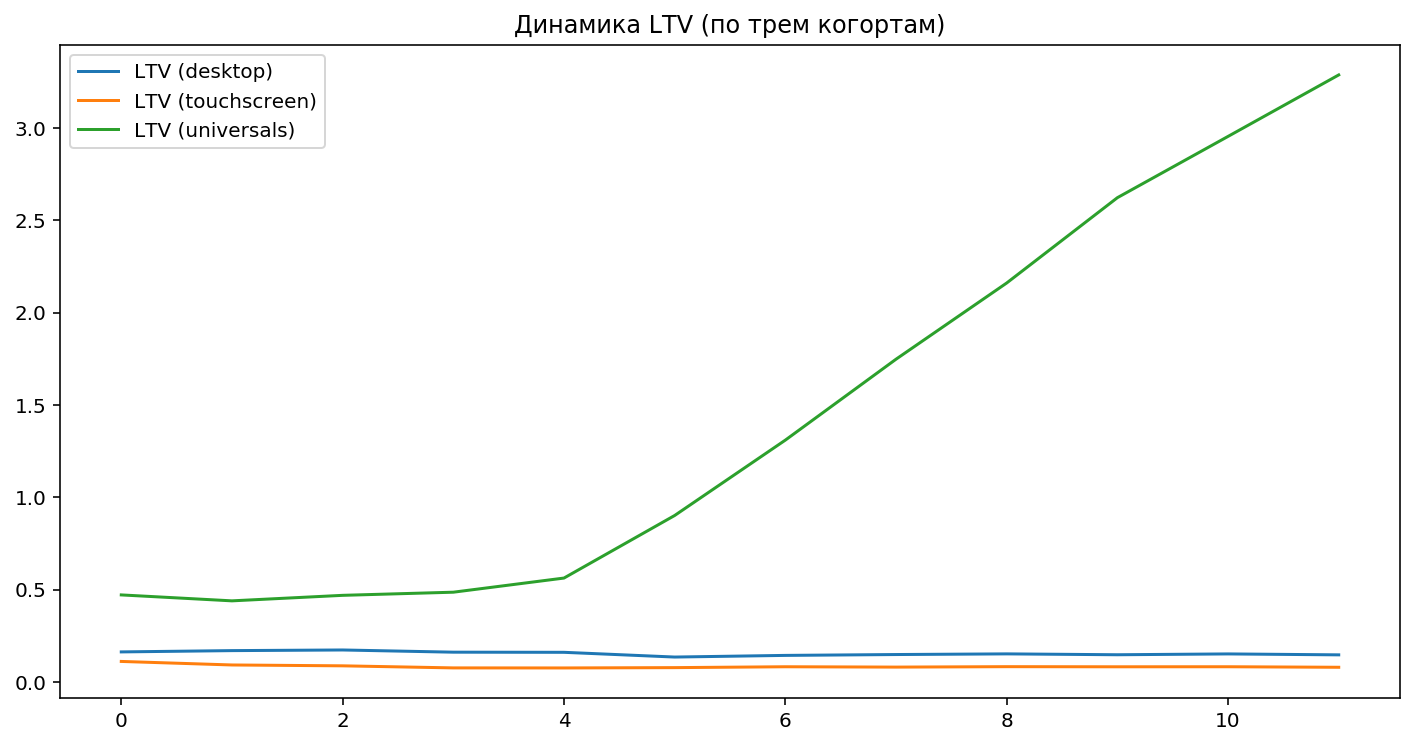

In [58]:
x = list(range(len(ltv_month_list_[0][:-1])))
y_2 = ltv_month_list_[1][:-1]
y_3 = ltv_month_list_[2][:-1]
y_4 = ltv_month_list_[3][:-1]

fig, ax = plt.subplots()

ax.plot(x, y_2, label="LTV (desktop)")
ax.plot(x, y_3, label="LTV (touchscreen)")
ax.plot(x, y_4, label="LTV (universals)")

ax.set_title("Динамика LTV (по трем когортам)")
ax.legend()

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

In [59]:
LTV_5 = s/len(y_1)
LTV_5

0.15753947501970014

In [60]:
# Для когорты desktop
LTV_5_dt = integrate.trapz(y_2, x)/len(y_2)
print(f"{LTV_5_dt:.6f} у.е.")
# Для когорты touchscreen
LTV_5_ts = integrate.trapz(y_3, x)/len(y_3)
print(f"{LTV_5_ts:.6f} у.е.")
# Для когорты universals
LTV_5_un = integrate.trapz(y_4, x)/len(y_4)
print(f"{LTV_5_un:.6f} у.е.")

0.142454 у.е.
0.077162 у.е.
1.295194 у.е.


### Результаты

In [61]:
result_df_all = pd.DataFrame(data=np.array([[LTV_2, LTV_3], [LTV_4, LTV_5]]), 
                         index=['Простой', 'Сложный'], columns=['За год', 'Помесячно'])
result_df_all

,За год,Помесячно
Простой,0.025361,0.724548
Сложный,0.172787,0.157539


In [62]:
result_df_kogorts = pd.DataFrame(data=np.array([[LTV_3_dt, LTV_3_ts, LTV_3_un], [LTV_5_dt, LTV_5_ts, LTV_5_un]]), 
                         index=['Простой', 'Сложный'], columns=['desktop', 'touchscreen', 'universals'])
result_df_kogorts

,desktop,touchscreen,universals
Простой,0.766507,0.315523,3.452757
Сложный,0.142454,0.077162,1.295194


Показатель LTV был посчитан 2-мя способами для всей выборки за весь период наблюдений и помесячно, а также для когорт (desktop, touchscreen, universals) помесячно.

**Способы расчета LTV:**
- "Простой". 𝐿𝑇𝑉=𝐿𝑖𝑓𝑒𝑡𝑖𝑚𝑒∗𝐴𝑅𝑃𝑈, где 𝐴𝑅𝑃𝑈  - средняя прибыль от одного клиента за период (Общий доход за период / Количество активных пользователей за период).

- "Сложный". 𝐿𝑇𝑉=𝐴𝑂𝑉∗𝑅𝑃𝑅∗𝐿𝑖𝑓𝑒𝑡𝑖𝑚𝑒, где 𝐴𝑂𝑉  - аverage order value, средняя стоимость заказа или средний чек,  𝑅𝑃𝑅  - repeat purchase rates, частота повторных покупок.

**Результаты:**

- "Простой". 𝐿𝑇𝑉=𝐿𝑖𝑓𝑒𝑡𝑖𝑚𝑒∗𝐴𝑅𝑃𝑈. Результаты для всей выборки за год: 0.025361, для всей выборки помесячно: 0.719262. Результаты для когорт desktop, touchscreen, universals соответственно: 0.762758, 0.315292, 3.472614.

- "Сложный". 𝐿𝑇𝑉=𝐴𝑂𝑉∗𝑅𝑃𝑅∗𝐿𝑖𝑓𝑒𝑡𝑖𝑚𝑒. Результаты для всей выборки за год: 0.172787, для всей выборки помесячно: 0.157543. Результаты для когорт desktop, touchscreen, universals соответственно: 0.142569, 0.076998, 1.294824.

- Отличия в значениях LTV объясняются различиями в способах расчета. Например результат 0.025361 у.е. был посчитан грубо и в знаменатель ARPU попали все пользователи за год, т.к. они все были активны в этот большой период. Значения для когорт посчитаны путем интегрирования показателей по итогам календарных месяцев с июня 2016 по май 2017 (1,5 часа наблюдений в июне 2017 фактически проигнорированы).

**Допущения:**

- В качестве 𝐿𝑖𝑓𝑒𝑡𝑖𝑚𝑒 примем интервал от первого действия (первый вход) до последнего (последний выход из сервиса) + некий период неактивности (время с последней активности, в течение которого мы еще готовы считать пользователя активным, т.е. вероятность его возвращения высока, а по истечении которого причислим пользователя к навечно покинувшим сервис, если конечно он потом неожиданно не вернется). Период неактивности посчитан как медианное значение величины интервала от предпоследнего до последнего визитов пользователей, которые приходили больше 1 раза.

- Пользователей можно кластеризовать на 3 когорты: "пользователи десктопов" (desktop), "пользователи устройств с сенсорным экраном" (touchscreen) и "универсалы" (universals).

**Выводы:**

- Визитов с source_id 8 совсем нет, а с 6 и 7 - крайне мало.

- Пользователи заходят с десктопов в 2.7 раз чаще, чем с устройств с сенсорным экраном.

- Пользователи из когорты universals имеют в 3.8 раза больший APRU, чем desktop, и в 11.5 раза больший APRU, чем touchscreen

- Примерно с 5-го месяца наблюдений LTV, Lifetime, ARPU, retention по всей выборке пользователей показывают устойчивую тенденцию к росту. С этого же времени количество новых пользователей начинает плавно снижаться из месяца в месяц, при этом ежемесячный прирост новых активных пользователей почти не меняется. Получается, что с этого момента мы стали лучше удерживать приходящую аудиторию. Возможно, это не случайно.

- Пользователи, практикующие визиты с десктопов - наиболее массовая аудитория, пользователи сенсорных устройств гораздо реже посещают сервис и делают мало покупок. При этом интересно, что пользователи, которые практикуют оба варианта, имеют значительно более высокие показатели LTV независимо от метода расчета. Можно сказать, что когорта desktop - массовый клиент, touchscreen - транзитные клиенты, а universals - самые лояльные.

**Рекомендации:**

- Продолжать удерживать пользователей из когорты desktop и universals.

- Переводить пользователей из когорты desktop в universals.

- Реализовывать меры по привлечению и удержанию клиентов из когорты touchscreen (м.б. переработать мобильную версию?).

- Решить, нужно ли нам работать над увеличением количества посещений с source_id 6,7 и 8.

- Классические рекомендации: увеличивать средний чек с помощью акций, кросс-продаж, рекомендательных систем, повышать частоту покупок с помощью программ лояльности и акций (например, для пользователей, имеющих некий статус), разобраться, из каких источников пользователи узнают о сервисе и нагонять трафик там, и конечно не перестаем развивать наш сервис и реагировать на поступающие отзывы.